In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 8


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
class Linear:

    def __init__(self, fan_in: int, fan_out: int, bias: bool = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.bias is not None else [])
# ----------------------------------------------------------------------------


class BatchNorm1d:

    def __init__(self, dim, momentum=0.1, epsilon=1e-5):
        self.momentum = momentum
        self.epsilon = epsilon

        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if x.ndim == 2:
            dim = 0
        elif x.ndim == 3:
            dim = (0, 1)

        if self.training:
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
# ----------------------------------------------------------------------------


class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
# ----------------------------------------------------------------------------


class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]
# ----------------------------------------------------------------------------


class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
# ----------------------------------------------------------------------------


class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
# ----------------------------------------------------------------------------

In [7]:
torch.manual_seed(42)

In [8]:
n_embd = 24
n_hidden = 128

layers = [Embedding(vocab_size, n_embd),
          FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False),
          BatchNorm1d(n_hidden), Tanh(),
          FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False),
          BatchNorm1d(n_hidden), Tanh(),
          FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False),
          BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size)]

model = Sequential(layers)

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 80000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if (i == 0) or (i == max_steps - 1) or ((i+1) % 10000 == 0):
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3167
   9999/ 200000: 2.1752
  19999/ 200000: 2.6999
  29999/ 200000: 1.6945
  39999/ 200000: 2.4181
  49999/ 200000: 2.0421
  59999/ 200000: 1.8536
  69999/ 200000: 1.8266
  79999/ 200000: 1.9946
  89999/ 200000: 2.0189
  99999/ 200000: 1.9638
 109999/ 200000: 1.5493
 119999/ 200000: 1.7961
 129999/ 200000: 1.8504
 139999/ 200000: 1.9007
 149999/ 200000: 1.4248
 159999/ 200000: 1.5598
 169999/ 200000: 1.6679
 179999/ 200000: 1.8671
 189999/ 200000: 1.9791
 199999/ 200000: 1.9196


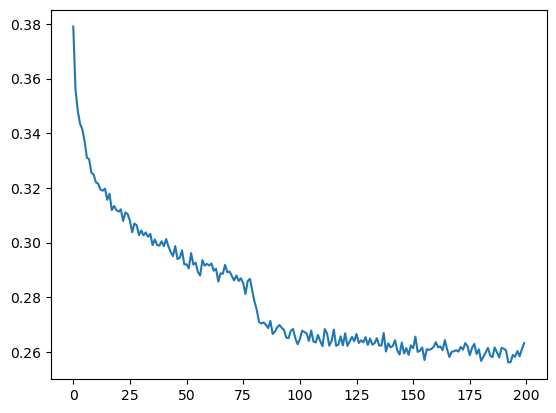

In [10]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.show()

In [11]:
for layer in model.layers:
    layer.training = False
    print(f"{layer.__class__.__name__}: {tuple(layer.out.shape)}")

Embedding: (32, 8, 24)
FlattenConsecutive: (32, 4, 48)
Linear: (32, 4, 128)
BatchNorm1d: (32, 4, 128)
Tanh: (32, 4, 128)
FlattenConsecutive: (32, 2, 256)
Linear: (32, 2, 128)
BatchNorm1d: (32, 2, 128)
Tanh: (32, 2, 128)
FlattenConsecutive: (32, 256)
Linear: (32, 128)
BatchNorm1d: (32, 128)
Tanh: (32, 128)
Linear: (32, 27)


In [12]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 1.7981075048446655
val 1.9909898042678833


In [13]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

aiyanah.
giusop.
jensen.
sabas.
angelife.
christell.
jedmccens.
zaipson.
briyah.
sylot.
zennica.
mythan.
daxphon.
petrit.
adalie.
jenissa.
glatipe.
manaswi.
yenneks.
desna.
